# Изучение закономерностей, определяющих успешность игр

### Описание проекта
Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

# Оглавление

* [Шаг 1. Общая информация](#chapter1)
    * [Описание данных](#section_1_1)
* [Шаг 2. Предобработка данных](#chapter2)
    * [2.1. Анализ общей информации](#section_2_1)
    * [2.2. Поле 'name'](#section_2_2)
    * [2.3. Поле 'year_of_release'](#section_2_3)
    * [2.4. Поле 'genre'](#section_2_4)
    * [2.5. Поле 'rating'](#section_2_5)
    * [2.6. Поле 'user_score'](#section_2_6)
    * [2.7. Поле 'total_sales'](#section_2_7)
* [Шаг 3. Анализ данных](#chapter3)
    * [3.1. Количество выпущенных игр по годам](#section_3_1)
    * [3.2. Продажи игр по платформам](#section_3_2)
         * [3.2.1 Время жизни платформ](#section_3_2_1)
         * [3.2.2 Платформы, живые к 2016 году](#section_3_2_2)
         * [3.2.3 Ящик с усами для платформ](#section_3_2_3)
    * [3.3. Диаграммы рассеяния объёмов продаж для оценок критиков и пользователей](#section_3_3)
    * [3.4. Распределение игр по жанрам](#section_3_4)
* [Шаг 4. Портрет пользователя каждого региона](#chapter4)
* [Шаг 5. Проверка гипотез](#chapter5)
    * [5.1. Гипотеза 1](#section_5_1)
    * [5.2. Гипотеза 2](#section_5_2)
* [Шаг 5. Общий вывод](#chapter5)

# Шаг 1. Общая информация <a class="anchor" id="chapter1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
import math
import seaborn as sns
from scipy.stats import levene

## Описание данных <a class="anchor" id="section_1_1"></a>

Откроем файлы с данными и изучим общую информацию.

In [2]:
try:
    games = pd.read_csv('datasets/games.csv')
except:
    games = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

# Шаг 2. Предобработка данных <a class="anchor" id="chapter2"></a>

## 2.1. Анализ общей информации <a class="anchor" id="section_2_1"></a>

Заменим названия столбцов (приведем к нижнему регистру).

In [4]:
games.columns = games.columns.str.lower()
games.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Проанализируем общую информацию о датафрейме.

In [6]:
# Функция возвращает имя датафрейма
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [7]:
# Функция возвращает информацию по каждому датафрейму из списка.
def pre_check(df_list):
    for df in df_list:
        print('=================================')
        print(get_df_name(df))
        print('_________________________________')
        print(df.info())
        print('Количество дубликатов: ', df.duplicated().sum())
        print('_________________________________')

In [8]:
pre_check([games])

games
_________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
Количество дубликатов:  0
_________________________________


## 2.2. Поле *'name'* <a class="anchor" id="section_2_2"></a>

Посмотрим на строки с отсутствующими именами.

In [9]:
games.loc[games['name'].isna()==True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Их можно сразу же удалить, т.к. мы не знаем ни названия игры, ни жанра.

In [10]:
games.dropna(subset = ['name'], inplace = True)

In [11]:
games = games.reset_index(drop=True);

In [12]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


## 2.3. Поле *'year_of_release'* <a class="anchor" id="section_2_3"></a>

Посмотрим на топ-20 самых часто встречающихся на разных платформах игр, для которых не указан год.

In [13]:
games.loc[(games['year_of_release'].isna() == True)]['name'].value_counts().head(20)

LEGO Harry Potter: Years 5-7                                      7
Rock Band                                                         4
Happy Feet Two                                                    4
Test Drive Unlimited 2                                            3
Bejeweled 3                                                       3
WRC: FIA World Rally Championship                                 3
The Lord of the Rings: War in the North                           2
The Golden Compass                                                2
NBA Live 2003                                                     2
Battle vs. Chess                                                  2
Captain America: Super Soldier                                    2
Silent Hill: Homecoming                                           2
Combat Elite: WWII Paratroopers                                   2
PDC World Championship Darts 2008                                 2
Robert Ludlum's The Bourne Conspiracy           

В названиях некоторых игр есть год. Можно предположить, что год релиза совпадает с годом в названии. Используем это предположение, чтобы дозаполнить год выпуска *year_of_release*.

Создадим словарь из имеющихся в столбце *year_of_release* уникальных значений, предварительно превратив их в строковые значения.

In [14]:
years_dict = games['year_of_release'].value_counts().keys().astype('int').astype('str')
years_dict

Index(['2008', '2009', '2010', '2007', '2011', '2006', '2005', '2002', '2003',
       '2004', '2012', '2015', '2014', '2013', '2016', '2001', '1998', '2000',
       '1999', '1997', '1996', '1995', '1994', '1993', '1981', '1992', '1991',
       '1982', '1986', '1989', '1983', '1990', '1987', '1988', '1985', '1984',
       '1980'],
      dtype='object')

In [15]:
# Функция, которая возвращает часть строки, если таковая есть в словаре years_dict
def string_part(the_string):
    for substring in years_dict:
        if substring in the_string:
            return(substring)

In [16]:
# Проверка:
string_part('FIFA Soccer 2004')

'2004'

Сделаем срез **games_no_year**, в котором *year_of_release* не указан.

In [17]:
games_no_year = games.loc[(games['year_of_release'].isna() == True)]
games_no_year

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16371,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16403,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16446,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16456,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Применим функцию **string_part** к датафрейму **games_no_year**.

In [18]:
year_from_name = games_no_year['name'].apply(string_part)
year_from_name

183      2004
377      2004
456      None
475      2006
609      None
         ... 
16371    2008
16403    None
16446    None
16456    None
16520    None
Name: name, Length: 269, dtype: object

Оставим в serias только ненулевые строки с их индексами.

In [19]:
games_with_year = year_from_name\
                .loc[year_from_name.isna() == False]\
                .astype('float')
games_with_year.name = 'year_from_name'
games_with_year

183      2004.0
377      2004.0
475      2006.0
1649     2003.0
2571     2009.0
3485     2002.0
4774     2003.0
5155     2003.0
5335     2013.0
5654     2005.0
5888     2003.0
8917     2005.0
13194    2011.0
13928    2006.0
15951    2008.0
16077    2007.0
16371    2008.0
Name: year_from_name, dtype: float64

Не густо. Объединим по индексам dataframe **games** и series **games_with_year**.

In [20]:
ggames = games.join(games_with_year, how='outer')
ggames.loc[375:380]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,year_from_name
375,Resident Evil 5,X360,2009.0,Action,2.11,0.93,0.12,0.34,83.0,7.5,M,NaN
376,Assassin's Creed: Brotherhood,X360,2010.0,Action,2.85,0.38,0.03,0.24,89.0,8.3,M,NaN
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E,2004.0
378,Battlefield 4,PS3,2013.0,Shooter,1.30,1.42,0.27,0.50,80.0,5.8,M,NaN
379,Batman: Arkham Asylum,X360,2009.0,Action,2.20,0.95,0.02,0.31,92.0,8.7,T,NaN
380,Battlefield 4,X360,2013.0,Shooter,2.15,1.01,0.02,0.31,79.0,5.6,M,NaN


Заполним столбец *year_of_release* в **games** найденными значениями, а оставшиеся пропуски заполним нолями. Это действие позволит оставить целочисленные значения лет и сохранит информацию о неполной информации.

In [21]:
games['year_of_release'] = ggames['year_of_release'].fillna(0) + ggames['year_from_name'].fillna(0)
games['year_of_release'] = games['year_of_release'].astype('int')
games

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16708,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16709,LMA Manager 2007,X360,2006,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16710,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,Spirits & Spells,GBA,2003,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [22]:
games.loc[375:380]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
375,Resident Evil 5,X360,2009,Action,2.11,0.93,0.12,0.34,83.0,7.5,M
376,Assassin's Creed: Brotherhood,X360,2010,Action,2.85,0.38,0.03,0.24,89.0,8.3,M
377,FIFA Soccer 2004,PS2,2004,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
378,Battlefield 4,PS3,2013,Shooter,1.30,1.42,0.27,0.50,80.0,5.8,M
379,Batman: Arkham Asylum,X360,2009,Action,2.20,0.95,0.02,0.31,92.0,8.7,T
380,Battlefield 4,X360,2013,Shooter,2.15,1.01,0.02,0.31,79.0,5.6,M


В части года выпуска мы сделали всё, что могли. Разве что не загуглили каждую игру отдельно.

## 2.4. Поле *'genre'* <a class="anchor" id="section_2_4"></a>

Посмотрим на жанры.

In [23]:
games['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

С жанрами всё очень даже хорошо и информативно.

## 2.5. Поле *'rating'* <a class="anchor" id="section_2_5"></a>

Посмотрим на категории рейтинга и сравним их с описанием в Wiki.

In [24]:
games['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
RP         3
K-A        3
AO         1
Name: rating, dtype: int64

https://en.wikipedia.org/wiki/Entertainment_Software_Rating_Board
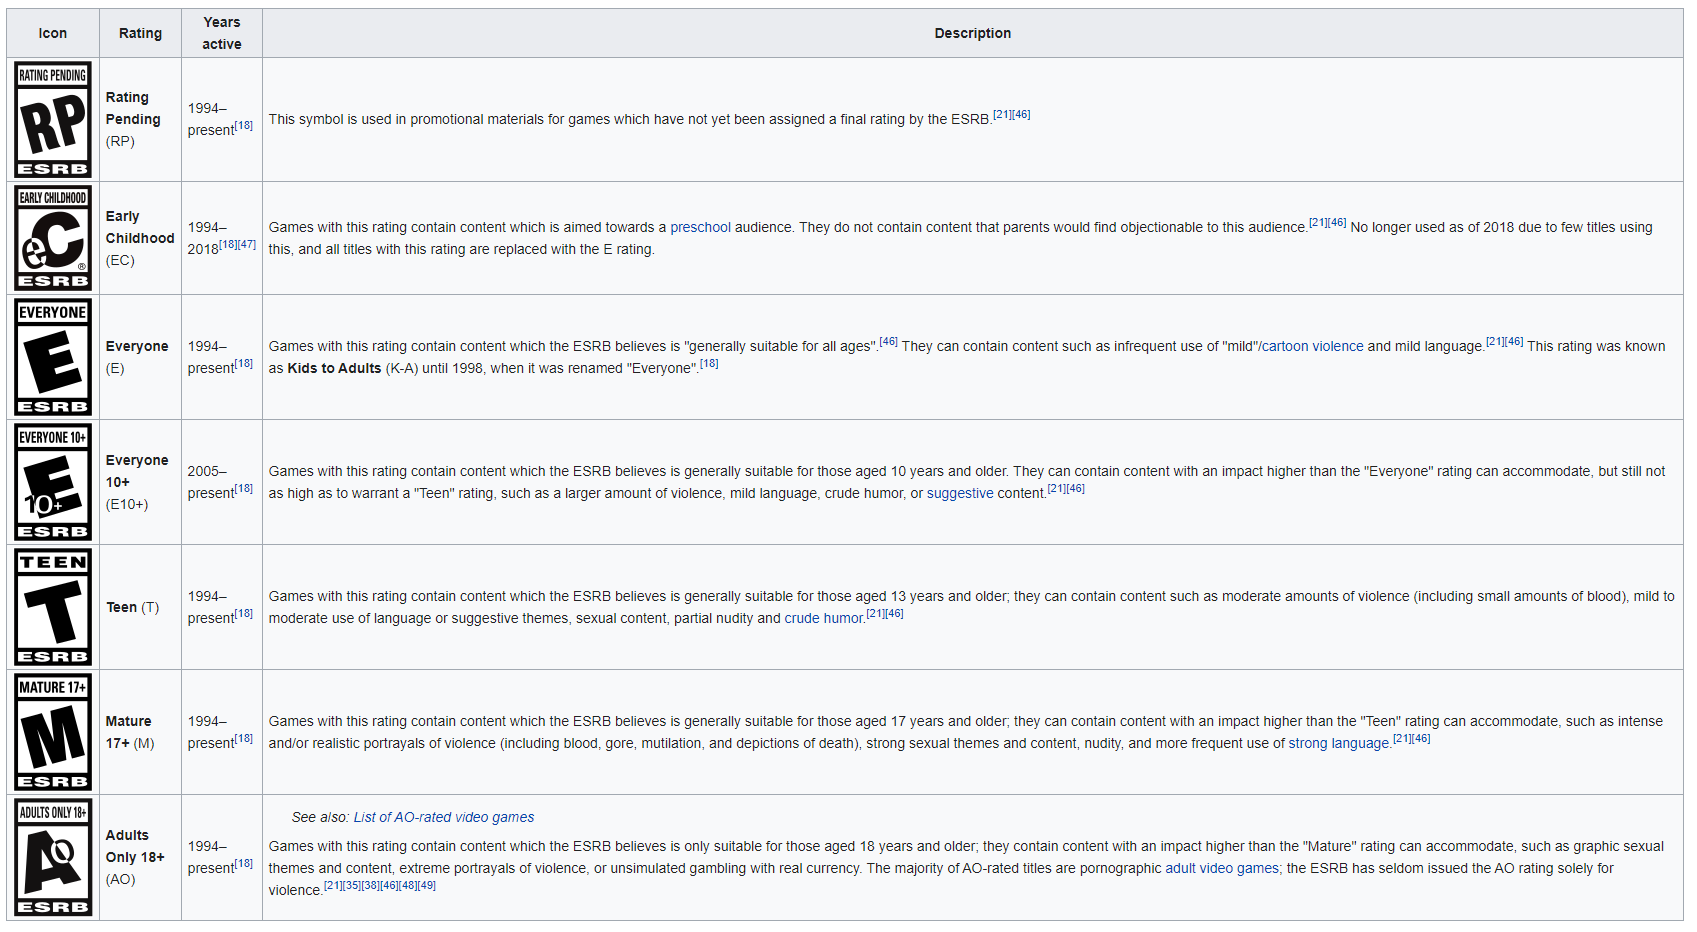

Категорию 'K-A' заменим на 'E', т.к. по факту это одна и та же категория. Остальные оставим без изменений. 

In [25]:
games['rating'] = games['rating'].replace('K-A','E')

Заменим значения `NaN` в поле **rating** на `unknown`. 

In [26]:
games['rating'] = games['rating'].fillna('unknown')

## 2.6. Поле *'user_score'* <a class="anchor" id="section_2_6"></a>

Посмотрим на значения в столбце *user_score*.

In [27]:
games['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
0.7       2
0.2       2
0.5       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

Больше всего значений 'tbd', что означает 'To Be Determined'. То есть пользовательских оценок слишком мало, чтобы выставить адекватный рейтинг. Заменим эти значения на NaN.

In [28]:
games['user_score'] = games['user_score'].replace('tbd',np.NaN)

In [29]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null object
rating             16713 non-null object
dtypes: float64(5), int64(1), object(5)
memory usage: 1.4+ MB


Приведем *user_score* к типу 'float'.

In [30]:
games['user_score'] = games['user_score'].astype('float')

Избавимся от оставшихся `NaN` в полях  **user_score** и **critic_score**. Заменим их на `0`, и при подсчёте рейтинга не будем учитывать нулевой рейтинг. Т.к. настолько плохие игры вряд ли существуют, мы заодно отметем хейтеров.

In [31]:
games['user_score'] = games['user_score'].fillna(0)
games['critic_score'] = games['critic_score'].fillna(0)

In [32]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16713 non-null int64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       16713 non-null float64
user_score         16713 non-null float64
rating             16713 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


## 2.7. Поле *'total_sales'* <a class="anchor" id="section_2_7"></a>

Посчитаем суммарные продажи во всех регионах и запишем их в столбец *total_sales*.

In [33]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales']

In [34]:
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,74.09
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0.0,0.0,unknown,39.47
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,32.23
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,29.82
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0.0,0.0,unknown,30.38


### Итог
В итоге у нас остались частично не заполнены только столбцы с оценками и рейтингом. Эти пропуски правильно оставить незаполненными, так как рейтинги нам взять неоткуда, так же, как и оценки пользователей и критиков.

- В столбце *critic_score* данные могут отсутствовать по нескольким причинам. Например, вероятно, критики оценивают не все игры, а только более-менее ожидаемые и популярные.
- В столбце *user_score* данные могут отсутствовать по нескольким причинам. Не все пользователи ставят оценки. Не для всех игр удалось собрать оценкки. Часть игр имела слишком мало оценок, чтобы иметь пользовательскую оценку.
- В столбце *rating* данные могут отсутствовать например потому, что организация ESRB начала своё существование в 1994 году, а мы имеем данные с 1980 года.

# Шаг 3. Исследовательский анализ данных <a class="anchor" id="chapter3"></a>

## 3.1. Количество выпущенных игр по годам <a class="anchor" id="section_3_1"></a>

Посмотрим, сколько игр выпускалось в разные годы. Сразу отбросим 0-й год.

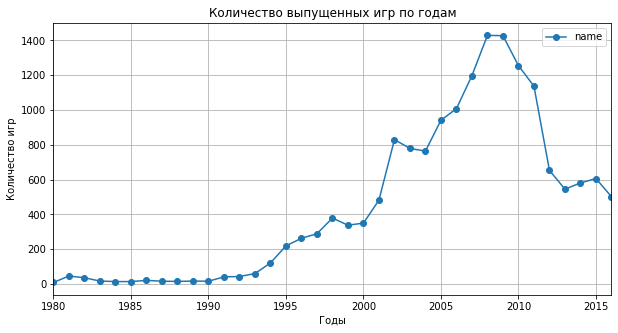

In [35]:
games.query('year_of_release >= 1980')\
                .pivot_table(index=('year_of_release'),\
                            values='name', aggfunc='count')\
                .plot(grid=True, figsize=(10, 5),style='o-')
plt.title('Количество выпущенных игр по годам')
plt.xlabel('Годы')
plt.ylabel('Количество игр')
plt.show()

## 3.2. Продажи игр по платформам <a class="anchor" id="section_3_2"></a>

Посмотрим, как менялись продажи игр по платформам.

In [36]:
# Функция строит горизонтальный бар по сводной таблице
def grouped_barh(df, index, value, aggfunc, title, xlabel, ylabel, top=50):
    df.pivot_table(index=index,\
                                values=value, aggfunc=aggfunc).sort_values(by=value, ascending=False)\
                                .head(top)\
                                .plot(kind='barh', grid=True, figsize=(10, 10))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

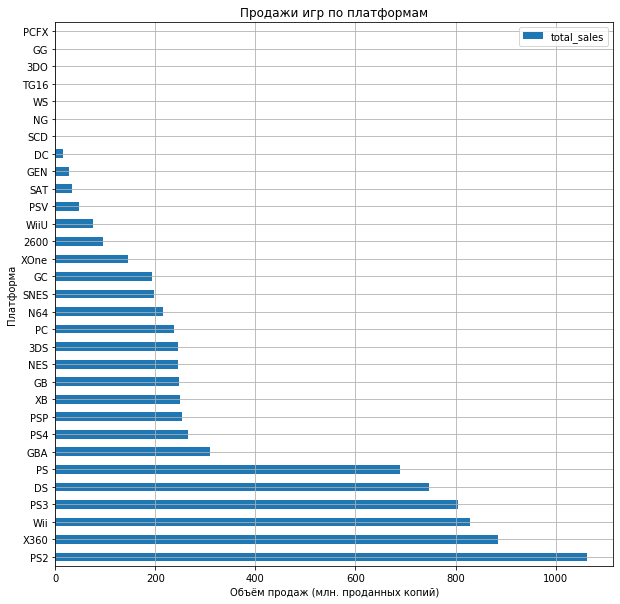

In [37]:
grouped_barh(games, 'platform', 'total_sales', 'sum', \
             'Продажи игр по платформам', 'Объём продаж (млн. проданных копий)', 'Платформа')

In [38]:
top_25 = games.pivot_table(index=('platform'),\
                            values='total_sales', aggfunc='sum')\
                            .sort_values(by='total_sales', ascending=False).head(25).reset_index()

Судя по всему, большинство копий продавалось для платформ не самых новых. Скорее всего для тех, которые дольше были на рынке.
Очевидно, нас будут платформы, игры для которых всё ещё выпускаются. То есть по 2016 год. Для этой цели будем выбирать из всех продаваемых платформ.

Но сначала посмотрим, за какой срок исчезают старые и появляются новые платформы. Возьмем топ-10 платформ.

### 3.2.1. Время жизни платформ <a class="anchor" id="section_3_2_1"></a>

In [39]:
# Функция для построения графиков
def single_plot(item, all_years=False):
    filt = games.query('(year_of_release >= 1980)&(platform in @item)')
    minimum_year = filt['year_of_release'].min()
    maximum_year = filt['year_of_release'].max()
    if all_years == False:
        if (maximum_year == 2016):
            filt.pivot_table(index=('year_of_release'),\
                            values='total_sales', aggfunc='sum')\
                            .plot(grid=True, figsize=(10, 3),style='o-')
            print('Игры для платформы', item, 'продавались с ', minimum_year,'по ', maximum_year)
            print('В продаже ', maximum_year-minimum_year, 'лет')
            print('Объём продаж в 2016: ', filt.loc[filt['year_of_release']==2016]['total_sales'].sum().round(1))
            print('Объём продаж в 2015: ', filt.loc[filt['year_of_release']==2015]['total_sales'].sum().round(1))
            print('Объём продаж в 2014: ', filt.loc[filt['year_of_release']==2014]['total_sales'].sum().round(1))
            print('Объём продаж в 2013: ', filt.loc[filt['year_of_release']==2013]['total_sales'].sum().round(1))
            plt.legend(["Объём продаж "+item])
            plt.xlabel('Годы')
            plt.ylabel('Объём продаж')
            plt.xlim([2005, 2016])
            plt.ylim([0, 200])
            plt.show()
    else:
        filt.pivot_table(index=('year_of_release'),\
                            values='total_sales', aggfunc='sum')\
                            .plot(grid=True, figsize=(10, 3),style='o-')
        print('Игры для платформы', item, 'продавались с ', minimum_year,'по ', maximum_year)
        print('В продаже ', maximum_year-minimum_year, 'лет')
        plt.legend(["Объём продаж "+item])
        plt.xlabel('Годы')
        plt.ylabel('Объём продаж')
        plt.xlim([1980, 2016])
        plt.ylim([0, 200])
        plt.show()

Игры для платформы PS2 продавались с  2000 по  2011
В продаже  11 лет


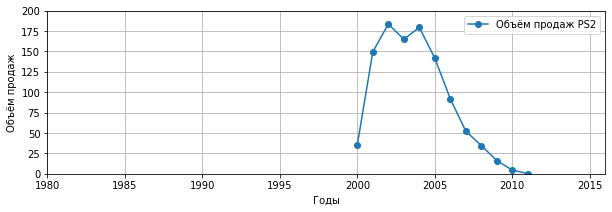

Игры для платформы X360 продавались с  2005 по  2016
В продаже  11 лет


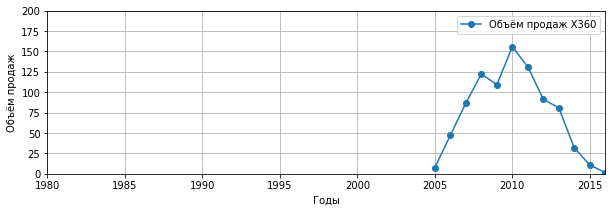

Игры для платформы Wii продавались с  2006 по  2016
В продаже  10 лет


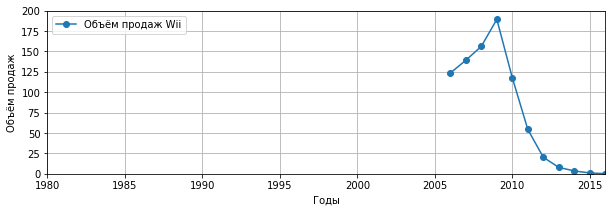

Игры для платформы PS3 продавались с  2006 по  2016
В продаже  10 лет


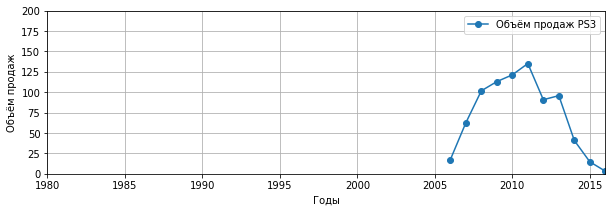

Игры для платформы DS продавались с  1985 по  2013
В продаже  28 лет


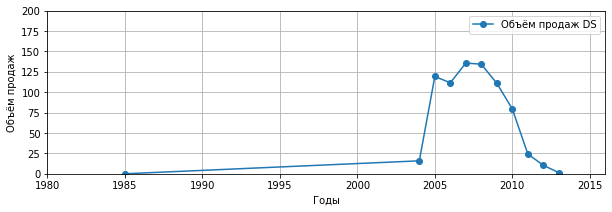

Игры для платформы PS продавались с  1994 по  2003
В продаже  9 лет


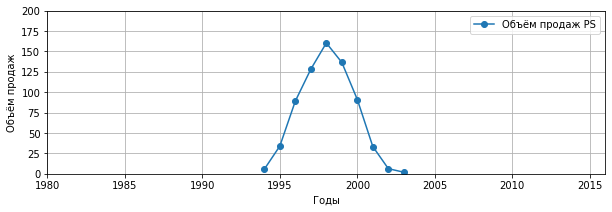

Игры для платформы GBA продавались с  2000 по  2007
В продаже  7 лет


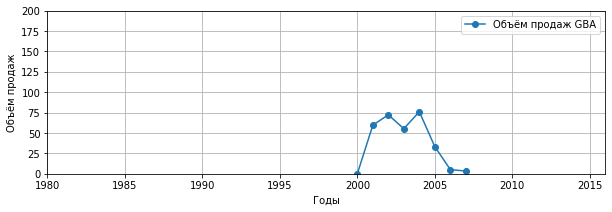

Игры для платформы PS4 продавались с  2013 по  2016
В продаже  3 лет


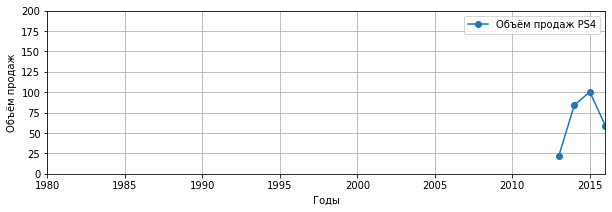

Игры для платформы PSP продавались с  2004 по  2015
В продаже  11 лет


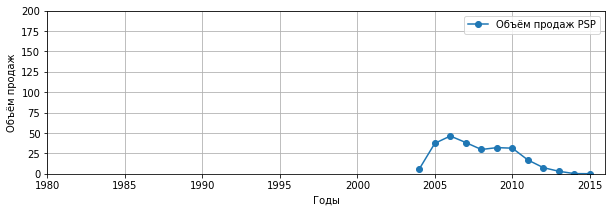

Игры для платформы XB продавались с  2000 по  2008
В продаже  8 лет


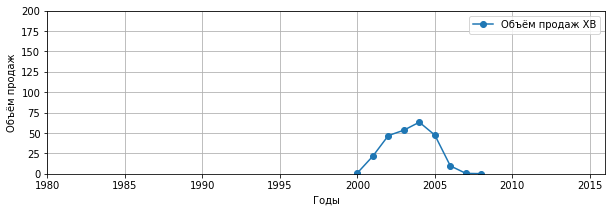

In [40]:
for platform in top_25['platform'].head(10):
    single_plot(platform, all_years=True)

Платформы "живут" 7-11 лет. В то время, пока одни платформы становятся менее популярны, другие наоборот - становятся более популярны. При этом набирают популярность платформы так же стремительно, как и теряют - за 2-3 года.

### 3.2.2. Платформы, живые к 2016 году <a class="anchor" id="section_3_2_2"></a>

Теперь посмотрим на более новые платформы, которые выпускаются по 2016.

Игры для платформы X360 продавались с  2005 по  2016
В продаже  11 лет
Объём продаж в 2016:  1.4
Объём продаж в 2015:  10.9
Объём продаж в 2014:  31.6
Объём продаж в 2013:  80.8


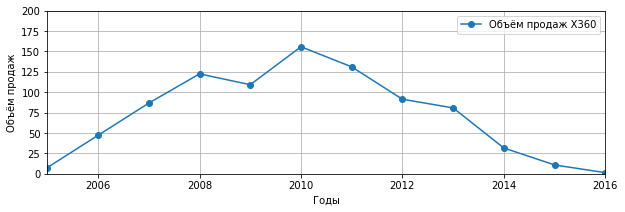

Игры для платформы Wii продавались с  2006 по  2016
В продаже  10 лет
Объём продаж в 2016:  0.2
Объём продаж в 2015:  1.0
Объём продаж в 2014:  3.4
Объём продаж в 2013:  7.9


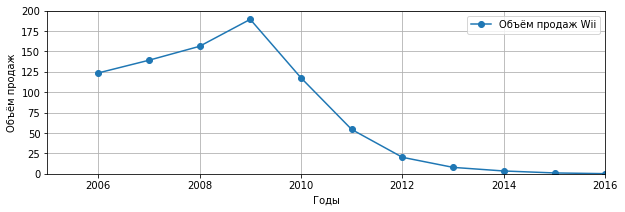

Игры для платформы PS3 продавались с  2006 по  2016
В продаже  10 лет
Объём продаж в 2016:  3.2
Объём продаж в 2015:  14.7
Объём продаж в 2014:  40.9
Объём продаж в 2013:  95.8


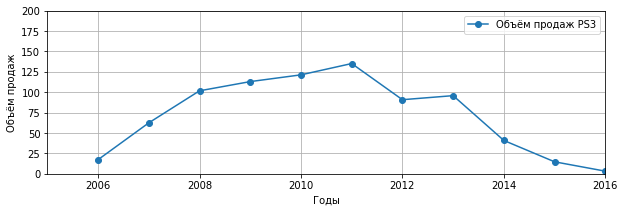

Игры для платформы PS4 продавались с  2013 по  2016
В продаже  3 лет
Объём продаж в 2016:  59.0
Объём продаж в 2015:  100.4
Объём продаж в 2014:  84.2
Объём продаж в 2013:  22.1


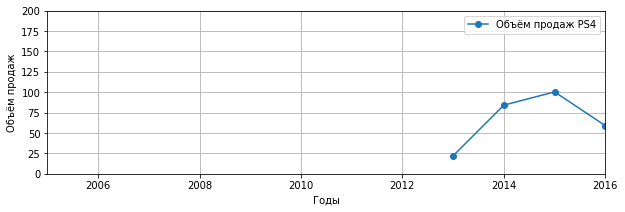

Игры для платформы 3DS продавались с  2011 по  2016
В продаже  5 лет
Объём продаж в 2016:  14.5
Объём продаж в 2015:  26.8
Объём продаж в 2014:  41.8
Объём продаж в 2013:  54.0


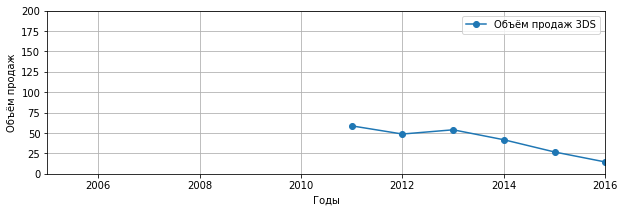

Игры для платформы PC продавались с  1985 по  2016
В продаже  31 лет
Объём продаж в 2016:  4.9
Объём продаж в 2015:  7.9
Объём продаж в 2014:  12.4
Объём продаж в 2013:  11.6


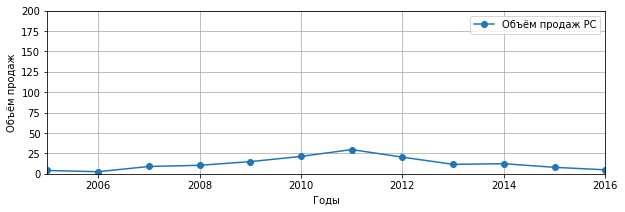

Игры для платформы XOne продавались с  2013 по  2016
В продаже  3 лет
Объём продаж в 2016:  23.9
Объём продаж в 2015:  54.7
Объём продаж в 2014:  49.3
Объём продаж в 2013:  17.2


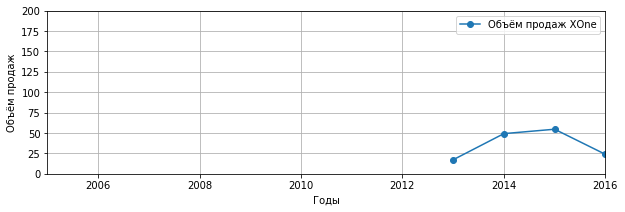

Игры для платформы WiiU продавались с  2012 по  2016
В продаже  4 лет
Объём продаж в 2016:  4.2
Объём продаж в 2015:  15.2
Объём продаж в 2014:  20.4
Объём продаж в 2013:  20.1


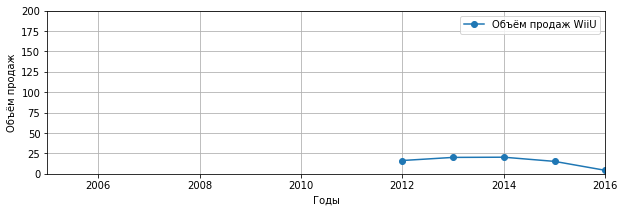

Игры для платформы PSV продавались с  2011 по  2016
В продаже  5 лет
Объём продаж в 2016:  4.1
Объём продаж в 2015:  5.9
Объём продаж в 2014:  10.6
Объём продаж в 2013:  9.1


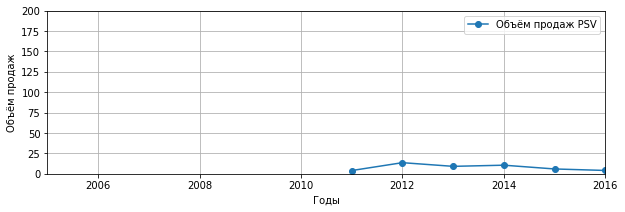

In [41]:
for platform in top_25['platform']:
    single_plot(platform)

С учётом того, что данные за 2016 год неполные, можно смотреть на тренд от 2014 к 2015 годам. Видно, что популярность стремительно возрастает для двух платформ: PS4 и XOne. 

Также, можно заметить, что на PC игры были в ходу всегда, но всё больше теряют позиции.

Пик популярности X360 приходился на 2010 год. В то время платформа конкурировала с PS3, пик популярности которой приходился на 2011 год. Вероятно, большая симпатия к этим двум платформам вытеснила платформу Nintendo (Wii), которая была на пике в 2009 году, а затем плавно затухала. Пришедшая в 2012 году на смену Wii платформа WiiU не смогла повторить успех предшественницы, т.к. объемы продаж копий видеоигр для платформы оставались на невысоком уровне, проигрывая лидерам. Из продуктов Nintendo более повезло портативной платформе 3DS, которая завоевала бОльшую популярность, чем портативная платформа от Sony PSV.

Также можно заметить, что портативные платформы с каждым годом пользовались всё меньшим спросом. Видимо, это связано с всё становившимися всё более доступными и более производительными смартфонами и отказу от кнопок в них. Игры стали адаптировать под смартфоны, и потребность в специальных портативных устройствах для игр отпала.

Будем считать актуальным период с 2013 года. Посмотрим, какие платформы попали в этот период.

In [42]:
actual_period = games['year_of_release'] >= 2013
games.loc[actual_period]['platform'].value_counts()

PS4     392
PSV     358
PS3     345
3DS     303
XOne    247
PC      190
X360    186
WiiU    115
PSP      67
Wii      23
DS        8
Name: platform, dtype: int64

### 3.2.3. Ящик с усами для платформ <a class="anchor" id="section_3_2_3"></a>

Построим гистограммы вместе с ящиком с усами для платформ, игры для которых всё ещё выпускаются. 
Очевидно, наиболее перспективны две из них: PS4 и XOne. Сравним их показатели с другими платформами, имеющими неплохие продажи.

In [43]:
# Функция для вычисления перцентиля
def get_percentile(df, column_name, percentile_rank):
    
    # Удалим NaN в столбце, отсортируем df, сбросим индексы
    try:
        # Если на входе - dataframe
        df = df.dropna(subset=[column_name]).sort_values(by=column_name).reset_index()
    except:
        # Если на входе - series
        df = df.dropna().sort_values().reset_index()
    # Найдём индекс перцентиля
    index = (len(df.index)-1) * percentile_rank / 100.0
    index = int(index)
    value = df.at[index, column_name]
    # Вернём элемент с этим индексом
    return value

In [44]:
# Функция для вычисления интерквартильного размаха.
def interquartile_range(df, column_name):
    
    p75 = get_percentile(df, column_name, 75)  # 75-й перцентиль
    p25 = get_percentile(df, column_name, 25)  # 25-й перцентиль
    iqr = p75 - p25  # интерквартильный размах
    return iqr

In [45]:
# Функция для вычисления левого уса.
def left_mustache(df, column_name):
    p25 = get_percentile(df, column_name, 25)
    iqr = interquartile_range(df, column_name)
    p0 = get_percentile(df, column_name, 0)
    if p25 - iqr*1.5 < p0:
        return (p0)
    return(p25 - iqr*1.5)

In [46]:
# Функция для вычисления правого уса
def right_mustache(df, column_name):
    p75 = get_percentile(df, column_name, 75)
    iqr = interquartile_range(df, column_name)
    p100 = get_percentile(df, column_name, 100)
    if p75 + iqr*1.5 > p100:
        return (p100)
    return(p75 + iqr*1.5)

In [47]:
# Функция для построения гистограммы по значениям, входящим в ящик с усами.
def box_mustache_hist(df, column_name, bins, xlabel, ylabel, title=False):
    
    # Отсортируем df, сбросим индексы
    df = df.sort_values(by=column_name).reset_index()
    split = df.loc[(df.loc[:, column_name] >= left_mustache(df, column_name))\
                  &(df.loc[:, column_name] <= right_mustache(df, column_name))][column_name]
    plt.figure(figsize=(12,5))
    plt.hist(split, bins=bins)
    if title == False:
        plt.title(column_name)
    else:
        plt.title(title)
    # Вертикальные линии для каждого перцентиля
    plt.axvline(get_percentile(df, column_name, 25), linestyle='--', color='blue')
    plt.axvline(get_percentile(df, column_name, 50), linestyle='-',  color='red')
    plt.axvline(get_percentile(df, column_name, 75), linestyle='--', color='magenta')
    plt.axvline(left_mustache(df, column_name), linestyle='-', color='black')
    plt.axvline(right_mustache(df, column_name), linestyle='-', color='black')
    plt.legend(["1-й квартиль","Медиана","3-й квартиль","Усы"])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim([-0.1, 1.7])  # Жёстко заданный диапазон для визуального сравнения нескольких графиков между собой.
                           # Диапазон свой для конкретной задачи. 
    plt.show()
    print('Среднее значение: ', round(df[column_name].mean(),2))
    print('Стандартное отклонение: ', round(df[column_name].std(),2))
    print('Медиана: ', get_percentile(df, column_name, 50))

Функция для построения ящика с усами без выбросов:

In [48]:
# Функция для построения ящика с усами без выбросов
def boxplot_nooutliers(df, column_name, ylabel=False):
    plt.ylim(left_mustache(df, column_name) - 0.05,\
             right_mustache(df, column_name) + 0.05)
    plt.ylabel(ylabel)
    df.boxplot(column=column_name)
    plt.show()

Словарь, содержащий платформы, продававшиеся после 2013 года:

In [49]:
platforms = games.loc[actual_period]['platform'].value_counts().keys()

Построим гистограммы для каждой из платформ за актуальный период.

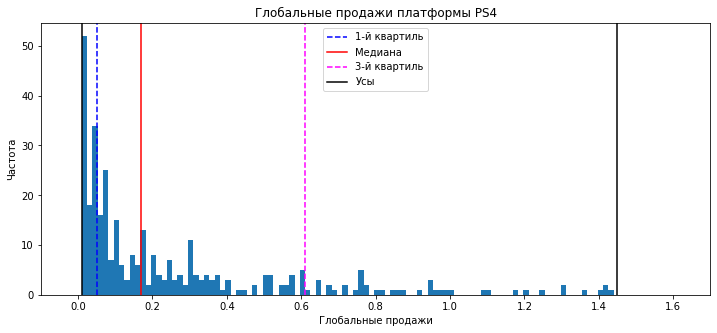

Среднее значение:  0.68
Стандартное отклонение:  1.36
Медиана:  0.17


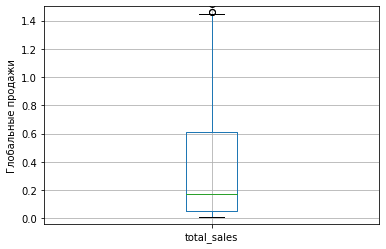

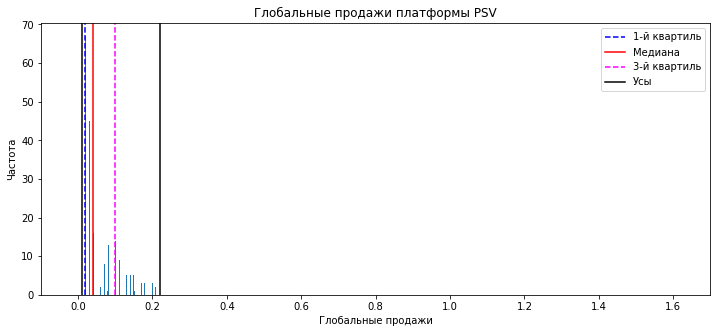

Среднее значение:  0.08
Стандартное отклонение:  0.13
Медиана:  0.04


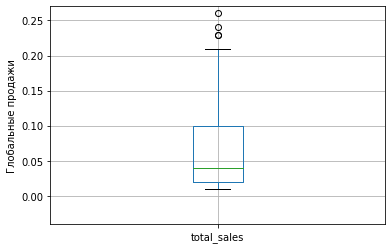

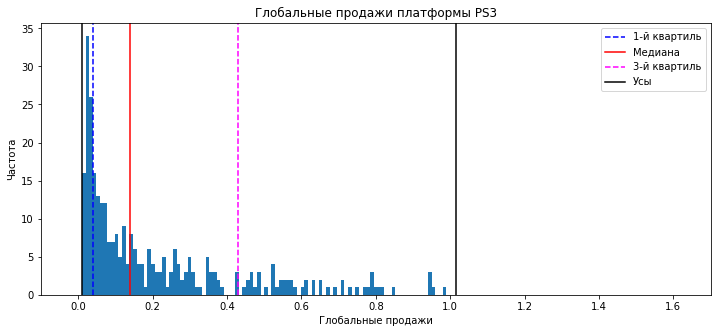

Среднее значение:  0.45
Стандартное отклонение:  1.2
Медиана:  0.14


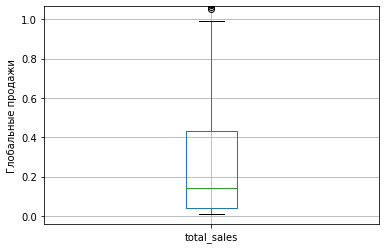

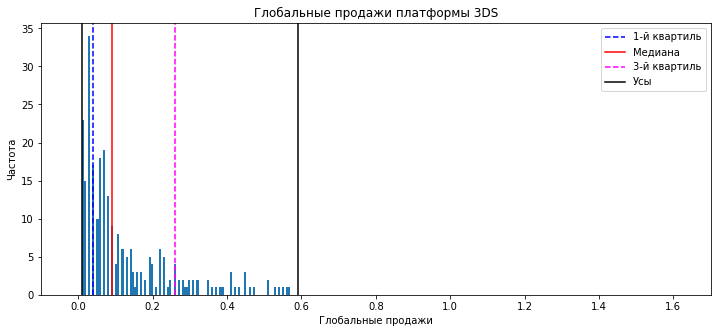

Среднее значение:  0.45
Стандартное отклонение:  1.31
Медиана:  0.09


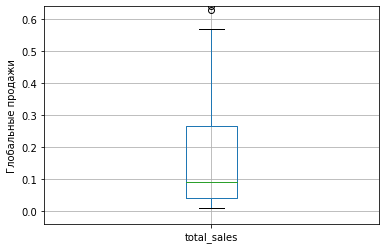

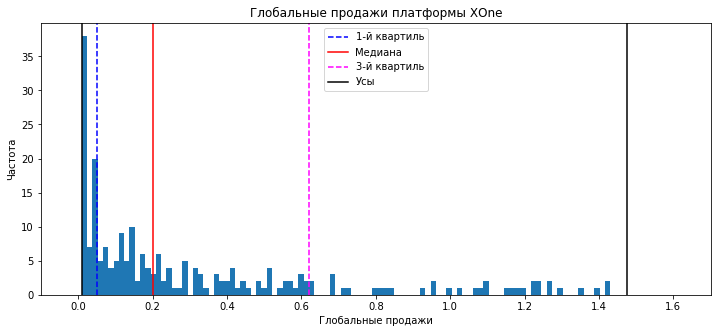

Среднее значение:  0.59
Стандартное отклонение:  0.94
Медиана:  0.2


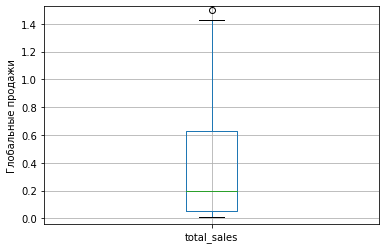

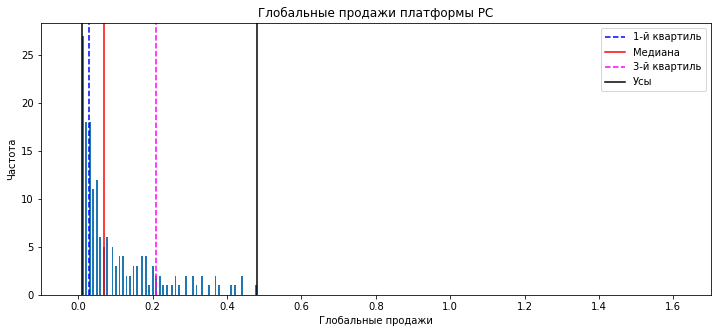

Среднее значение:  0.19
Стандартное отклонение:  0.32
Медиана:  0.07


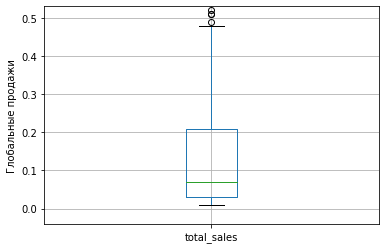

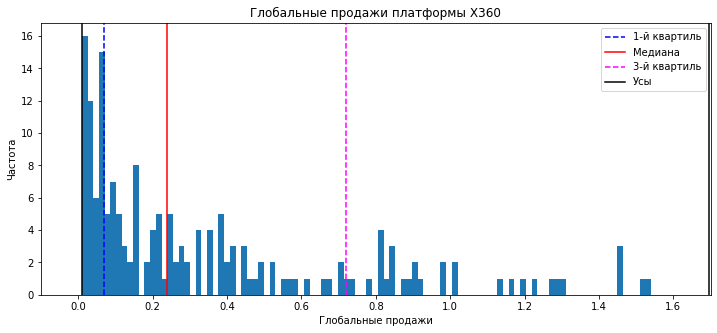

Среднее значение:  0.67
Стандартное отклонение:  1.52
Медиана:  0.24


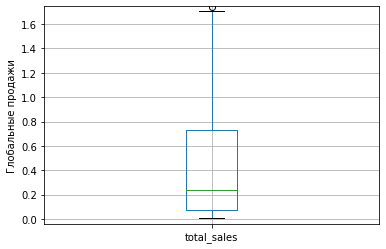

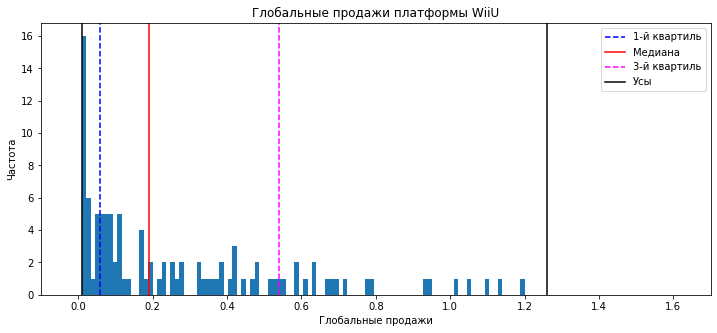

Среднее значение:  0.52
Стандартное отклонение:  0.97
Медиана:  0.19


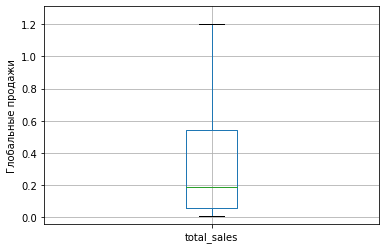

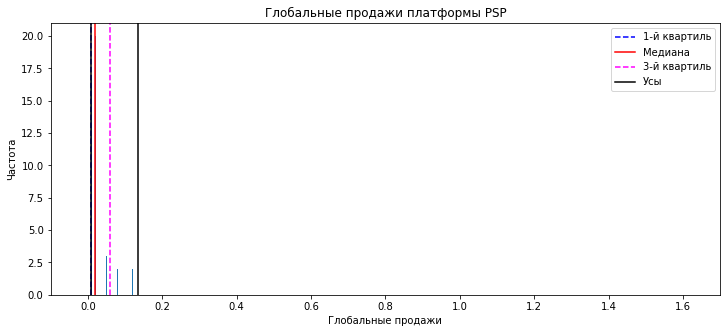

Среднее значение:  0.05
Стандартное отклонение:  0.06
Медиана:  0.02


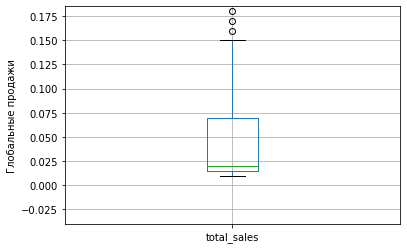

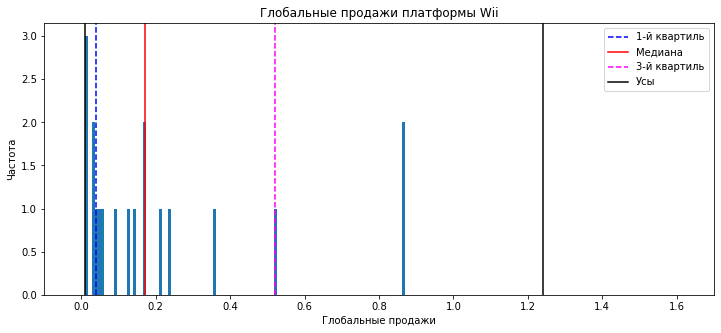

Среднее значение:  0.55
Стандартное отклонение:  0.84
Медиана:  0.16999999999999998


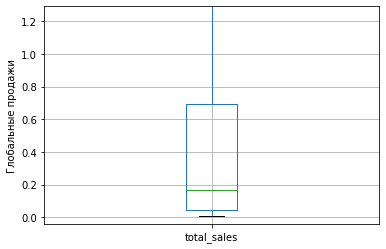

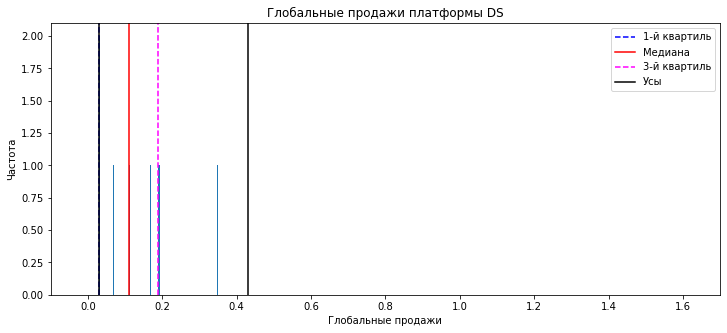

Среднее значение:  0.18
Стандартное отклонение:  0.16
Медиана:  0.11


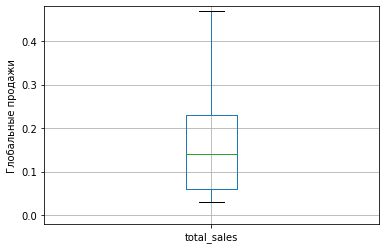

In [50]:
for platform in platforms:
    box_mustache_hist(games.loc[actual_period & (games['platform']==platform)], 'total_sales', 100, \
                      'Глобальные продажи', 'Частота', ('Глобальные продажи платформы '+ platform))
    boxplot_nooutliers(games.loc[actual_period & (games['platform']==platform)], 'total_sales',\
                       'Глобальные продажи')
    print('=========================================================================================')

Можно сделать вывод о том, что Sony сделала выводы из опыта предыдущей платформы, и средний объём продаж у PS4 стал выше, чем у основного конкурента от Microsoft - Xbox One. Ранее PS3 немного уступал по этому показателю X360. Хотя жизненный цикл этих платформ только начался, можно судить о том, что у них есть потенциал к тому, чтобы сохранить средний объём продаж в районе 0.6-0.7 миллионов копий. 

Платформа WiiU также имеет неплохое среднее за счёт меньшего количества игр с околонулевыми продажами по сравнению с PS4 и Xbox One. Для платформ PSP, Wii и DS слишком мало данных для более-менее релевантного анализа.

## 3.3. Диаграммы рассеяния объёмов продаж для оценок критиков и пользователей<a class="anchor" id="section_3_3"></a>

Посмотрим, как коррелируют продажи с рейтингами внутри каждой из популярных платформ.

Возьмём данные с ненулевыми оценками за актуальный период.

In [51]:
#Функция строит два графика для платформы - "Продажи от оценок критиков" и "Продажи от оценок пользователей"
def score_sales(platform):
    if (games.loc[actual_period &(games['platform']==platform)\
              &(games['critic_score'] > 0)]['critic_score'].sum() > 0)\
    &(games.loc[actual_period &(games['platform']==platform)\
              &(games['user_score'] > 0)]['user_score'].sum() > 0):
        
        games.loc[actual_period &(games['platform']==platform)\
                  &(games['critic_score'] > 0)]\
                    .plot(x='critic_score', y='total_sales', kind='scatter', alpha=0.3);
        plt.title('Продажи от оценок критиков '+ platform)
        plt.xlabel('Оценка критиков')
        plt.ylabel('Объём продаж')
        plt.show()
        games.loc[actual_period &(games['platform']==platform)\
                  &(games['user_score'] > 0)]\
                    .plot(x='user_score', y='total_sales', kind='scatter', alpha=0.3);
        plt.title('Продажи от оценок пользователей '+ platform)
        plt.xlabel('Оценка пользователей')
        plt.ylabel('Объём продаж')
        plt.show()
        print('Корреляция между отзывами критиков и продажами', platform, ': ', \
              games.loc[actual_period &(games['platform']==platform)]['critic_score']\
              .corr(games.loc[actual_period &(games['platform']==platform)]['total_sales']).round(2))    
        print('Корреляция между отзывами пользователей и продажами', platform, ': ', \
              games.loc[actual_period &(games['platform']==platform)]['user_score']\
              .corr(games.loc[actual_period &(games['platform']==platform)]['total_sales']).round(2))
        print('==============================================================')
    

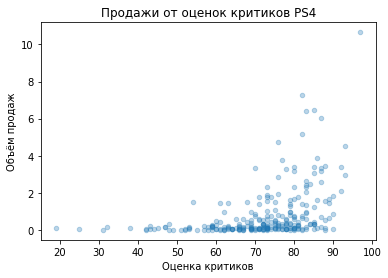

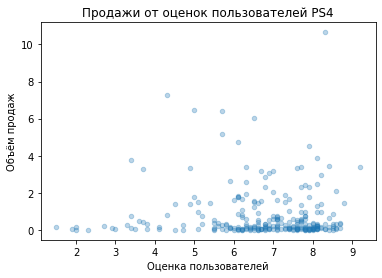

Корреляция между отзывами критиков и продажами PS4 :  0.23
Корреляция между отзывами пользователей и продажами PS4 :  0.11


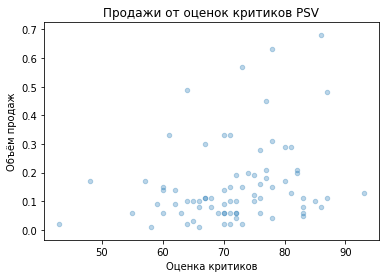

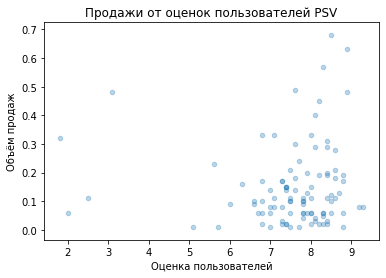

Корреляция между отзывами критиков и продажами PSV :  0.31
Корреляция между отзывами пользователей и продажами PSV :  0.31


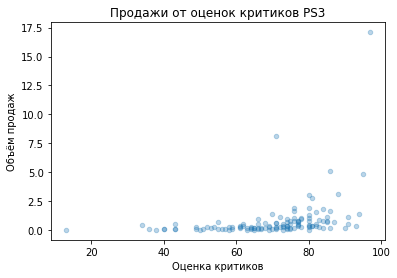

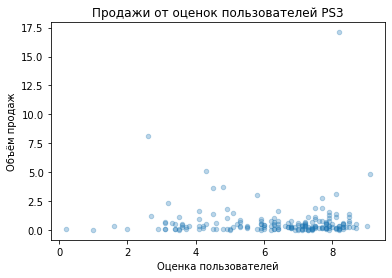

Корреляция между отзывами критиков и продажами PS3 :  0.28
Корреляция между отзывами пользователей и продажами PS3 :  0.2


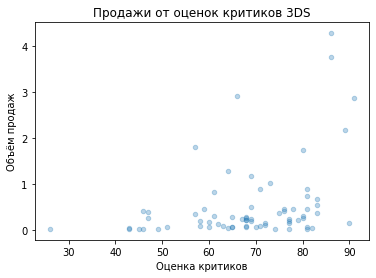

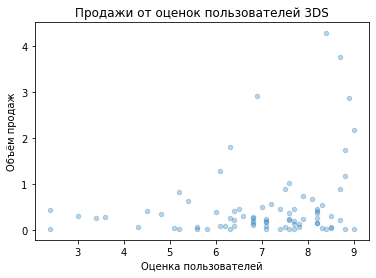

Корреляция между отзывами критиков и продажами 3DS :  0.06
Корреляция между отзывами пользователей и продажами 3DS :  0.04


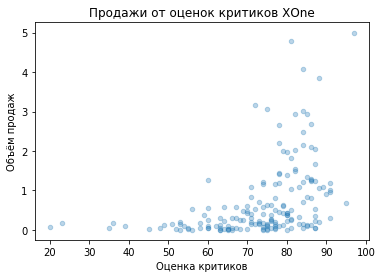

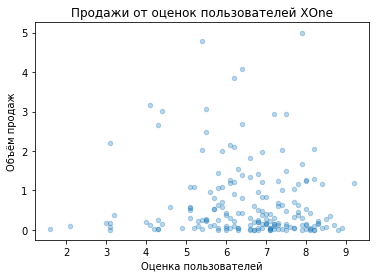

Корреляция между отзывами критиков и продажами XOne :  0.28
Корреляция между отзывами пользователей и продажами XOne :  0.12


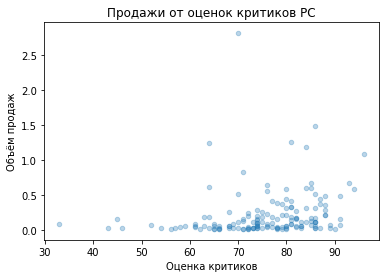

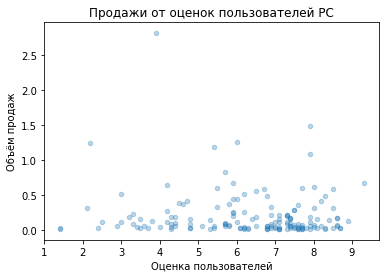

Корреляция между отзывами критиков и продажами PC :  0.19
Корреляция между отзывами пользователей и продажами PC :  0.04


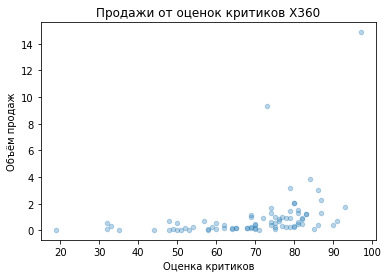

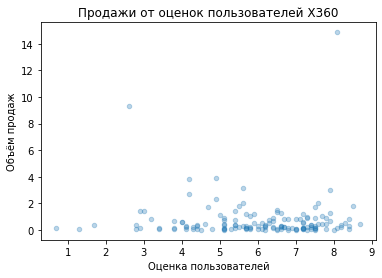

Корреляция между отзывами критиков и продажами X360 :  0.25
Корреляция между отзывами пользователей и продажами X360 :  0.07


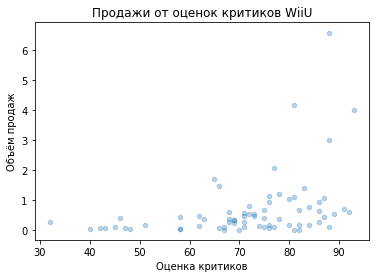

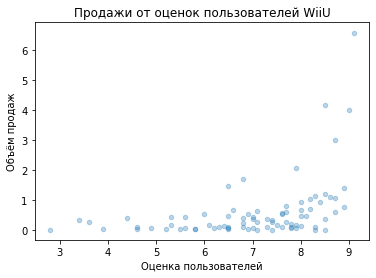

Корреляция между отзывами критиков и продажами WiiU :  0.29
Корреляция между отзывами пользователей и продажами WiiU :  0.25


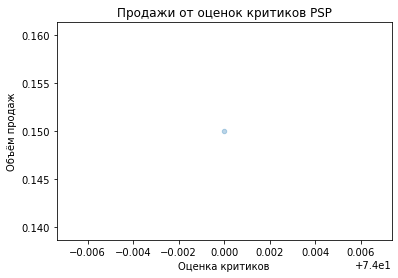

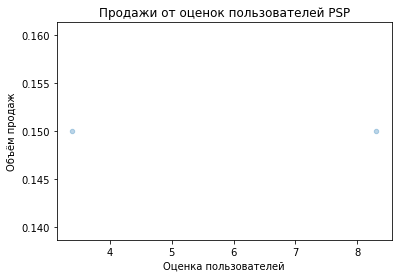

Корреляция между отзывами критиков и продажами PSP :  0.21
Корреляция между отзывами пользователей и продажами PSP :  0.27


In [52]:
for platform in platforms:
    score_sales(platform)

Чем выше рейтинги игр, тем проще объёмам продаж преодолевать гравитацию нулевого значения. Причем оценки критиков как правило лучше отражают популярность игр для платформы, чем оценки пользователей.

## 3.4. Распределение игр по жанрам <a class="anchor" id="section_3_4"></a>

Посмотрим на общее распределение игр по жанрам за всю доступную историю. Сравним количество выпускаемых игр в каждом жанре с суммарным количеством продаж в каждом жанре.

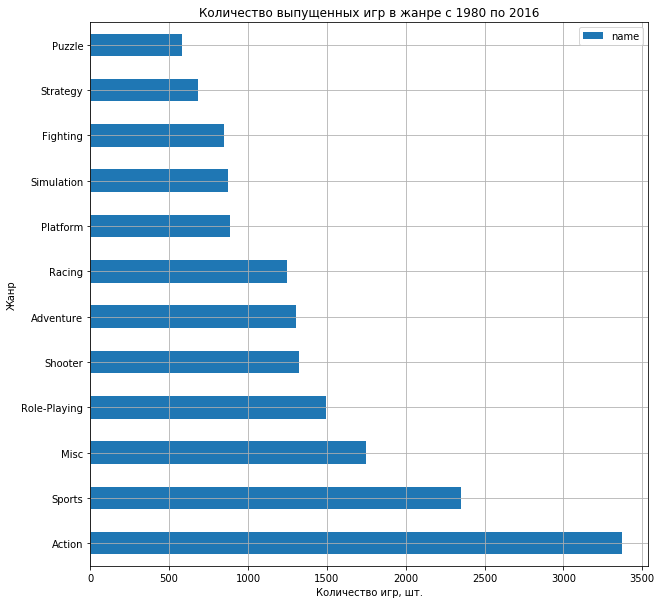

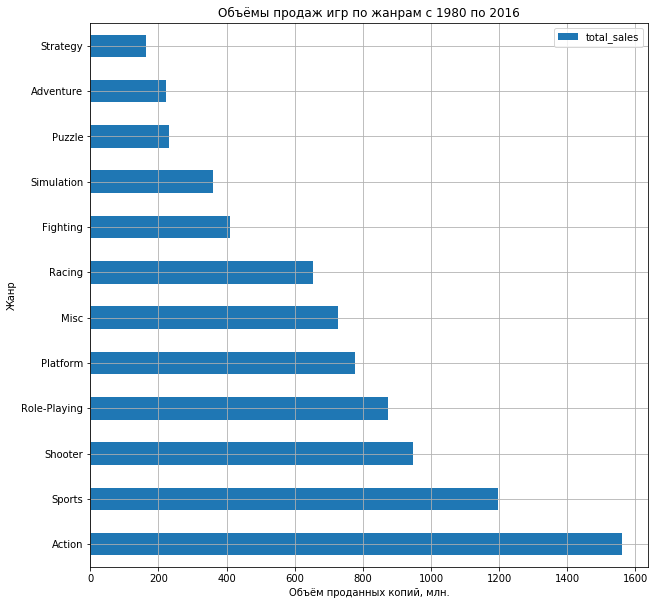

In [53]:
grouped_barh(games, 'genre', 'name', 'count', \
             'Количество выпущенных игр в жанре с 1980 по 2016', 'Количество игр, шт.', 'Жанр')
grouped_barh(games, 'genre', 'total_sales', 'sum', \
             'Объёмы продаж игр по жанрам с 1980 по 2016', 'Объём проданных копий, млн.', 'Жанр')

- 1-е и 2-е места по объёму проданных копий дастаются соответственно играм в жанрах Action и Sports. Игры в этих жанрах выпускаются в большем количестве, чем другие.
- 3-е место по объёму проданных копий занимают игры в жанре Shooter. Хотя по количеству экземпляров они на 5-м месте. А игры в жанре Misc, которые по количеству экземпляров на 3-м месте, по объёму проданных копий занимают 6-е место.
- 4-е и 5-е места занимают игры в жанре Role-Playing и Platform соответственно. 

Посмотрим, какие игры были более популярны в последние 3 года (с 2013 по 2016).

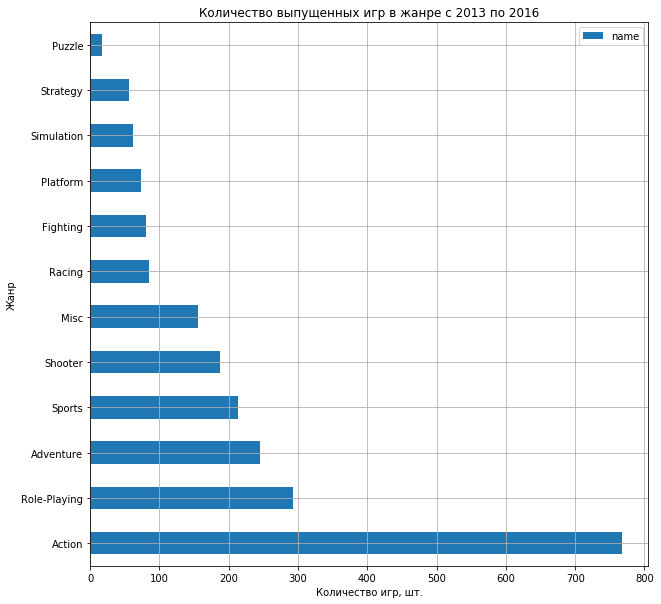

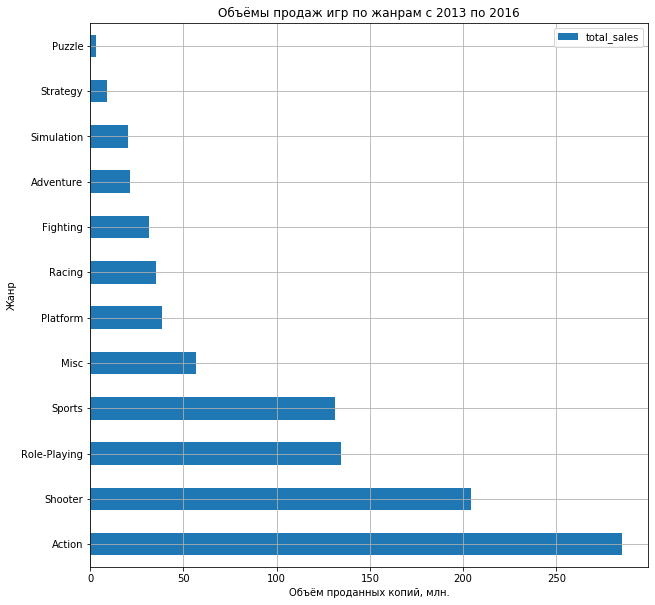

In [54]:
grouped_barh(games.loc[actual_period], 'genre', 'name', 'count', \
             'Количество выпущенных игр в жанре с 2013 по 2016', 'Количество игр, шт.', 'Жанр')
grouped_barh(games.loc[actual_period], 'genre', 'total_sales', 'sum', \
             'Объёмы продаж игр по жанрам с 2013 по 2016', 'Объём проданных копий, млн.', 'Жанр')

- 1-е место по объёму проданных копий по-прежнему занимают игры в жанре Action.
- На 2-е место по объёму проданных копий поднялись игры в жанре Shooter. 
- 3-е место по объёму проданных копий завоевали Role-Playing игры. 
- Игры в жанре Sports переместились со 2-го на 4-е место. 

### Вывод.

Мы видим, что предпочтения по платформам и жанрам игр со временем меняются, поэтому будем считать актуальными данные за последние 3 года, чтобы платформы, уходящие в прошлое, не слишком сильно влияли на результаты. Таким образом, можно планировать 2017-й исходя из последних трендов.

# Шаг 4. Портрет пользователя каждого региона <a class="anchor" id="chapter4"></a>

Определим для пользователя  каждого региона самые популярные платформы.

In [55]:
# Функция строит 3 горизонтальных бара рядом друг с другом для трёх колонок одного датафрейма, 
# группируемых по одному и тому же признаку
def barh3_compare(df, 
                  index, 
                  value1, value2, value3, 
                  aggfunc, 
                  title, title1, title2, title3, 
                  xlabel, ylabel, top=5):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)
    fig.suptitle(title)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)
    ax1.set_title(title1)
    pivot1 = df.pivot_table(index=index,\
                                values=value1, aggfunc=aggfunc).sort_values(by=value1, ascending=False)\
                                .head(top)
    pivot1.plot(kind='barh', grid=True, figsize=(15, 5), ax=ax1)
    
    ax2.set_title(title2)
    pivot2 = df.pivot_table(index=index,\
                                values=value2, aggfunc=aggfunc).sort_values(by=value2, ascending=False)\
                                .head(top)
    pivot2.plot(kind='barh', grid=True, figsize=(15, 5), ax=ax2)
    
    ax3.set_title(title3)
    pivot3 = df.pivot_table(index=index,\
                                values=value3, aggfunc=aggfunc).sort_values(by=value3, ascending=False)\
                                .head(top)
    pivot3.plot(kind='barh', grid=True, figsize=(15, 5), ax=ax3)
    
    ax1.set(xlabel=xlabel, ylabel=ylabel)
    ax2.set(xlabel=xlabel, ylabel=ylabel)
    ax3.set(xlabel=xlabel, ylabel=ylabel)
    
    plt.show()
    print('Всего в топ -',top, title1, ': ', pivot1.reset_index()[value1].sum().round(1))
    print('Всего в топ -',top, title2, ': ', pivot2.reset_index()[value2].sum().round(1))
    print('Всего в топ -',top, title3, ': ', pivot3.reset_index()[value3].sum().round(1))

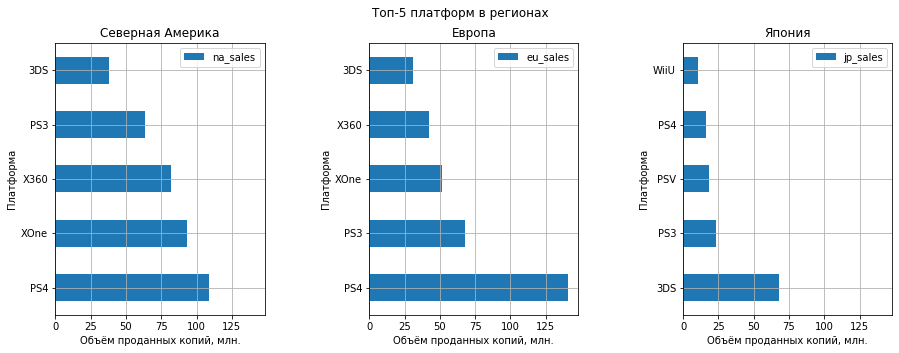

Всего в топ - 5 Северная Америка :  385.2
Всего в топ - 5 Европа :  334.0
Всего в топ - 5 Япония :  136.6


In [56]:
barh3_compare(games.loc[actual_period], 'platform', 'na_sales', 'eu_sales', 'jp_sales', 'sum', \
             'Топ-5 платформ в регионах', 'Северная Америка', 'Европа', 'Япония', \
              'Объём проданных копий, млн.', 'Платформа', 5)

- Пользователи Северной Америки, как и пользователи Европы предполчитают PS4 другим платформам. 
- В Северной Америке XOne не так сильно отстаёт от PS4. 
- В Европе вероятно пользователи постепенно переходят с платформы PS3 на PS4 и XOne, но последняя проигрывает.
- В Японии пользователи предпочитают отечественного производителя, однако (внезапно) более популярной платформой является 3DS, а не PS4.
- Больше всего игр для популярных платформ продаётся в Северной Америке, чуть меньше - в Европе. 
- В Японии продаётся в 2-3 раза меньше игр.

Определим для пользователя каждого региона самые популярные жанры.

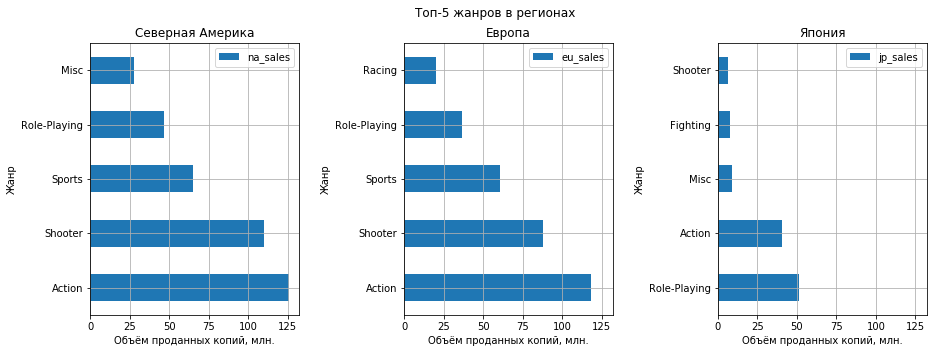

Всего в топ - 5 Северная Америка :  375.0
Всего в топ - 5 Европа :  323.9
Всего в топ - 5 Япония :  115.0


In [57]:
barh3_compare(games.loc[actual_period], 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'sum', \
             'Топ-5 жанров в регионах', 'Северная Америка', 'Европа', 'Япония', \
              'Объём проданных копий, млн.', 'Жанр', 5)

- В Северной Америке и Европе пользуются популярностью одни и те же жанры, за исключением 5-й строчки. 
- Япония снова отличается - здесь всё иначе.

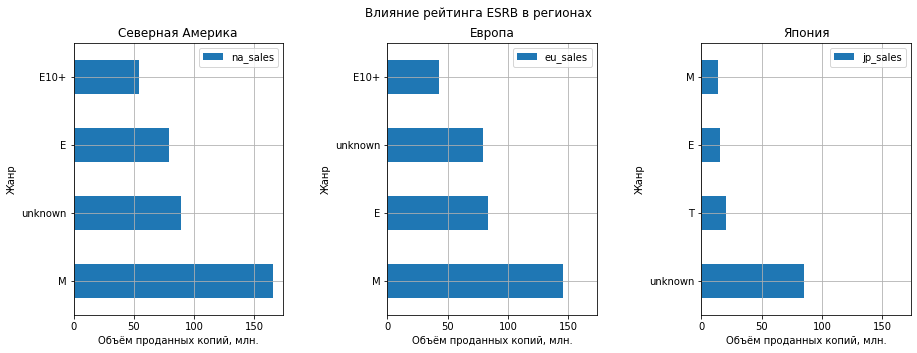

Всего в топ - 4 Северная Америка :  388.0
Всего в топ - 4 Европа :  350.5
Всего в топ - 4 Япония :  134.9


In [58]:
barh3_compare(games.loc[actual_period], 'rating', 'na_sales', 'eu_sales', 'jp_sales', 'sum', \
             'Влияние рейтинга ESRB в регионах', 'Северная Америка', 'Европа', 'Япония', \
              'Объём проданных копий, млн.', 'Жанр', 4)

- И снова в Северной Америке и Европе схожие картины. В основном играют пользователи категорий Mature(17+) и Everyone.
    
- Вероятно, в Японии своя система рейтингов, поэтому точно определить категории пользователей мы не можем.

# Шаг 5. Проверка гипотез <a class="anchor" id="chapter5"></a>

## 5.1. Гипотеза 1<a class="anchor" id="section_5_1"></a>

**Гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые.**

Будем учитывать данные с ненулевым рейтингом.

In [59]:
# Функция сравнивает плотности вероятностей столбца, одинакового для двух датафреймов
def pd_compare(df1, df2, column, title='', label1='', label2='', xlabel=''):
    df1_column = df1[column]
    df2_column = df2[column]

    plt.figure(figsize=(12,6))
    plt.title(title)
    sns.kdeplot(df1_column, color='r', shade=True, Label=label1)
    sns.kdeplot(df2_column, color='b', shade=True, Label=label2)
    plt.xlabel(xlabel) 
    plt.ylabel('Плотность вероятности')
    plt.show()
    print("Медиана", label1, "\t:\t\t\t","p50 =", round(get_percentile(df1_column, column, 50), 2))
    print("Медиана", label2, "\t:\t\t\t","p50 =", round(get_percentile(df2_column, column, 50), 2))
    print("Среднее", label1, "\t:\t\t\t","μ =", round(df1_column.mean(), 2))
    print("Среднее", label2, "\t:\t\t\t","μ =", round(df2_column.mean(), 2))
    print("Дисперсия", label1, "\t:\t\t\t","s^2 =", round(np.var(df1_column, ddof=1), 2))
    print("Дисперсия", label2, "\t:\t\t\t","s^2 =", round(np.var(df2_column, ddof=1), 2))
    print("Стандартное отклонение", label1, "\t:\t","s =", round(np.std(df1_column, ddof=1), 2))
    print("Стандартное отклонение", label2, "\t:\t", "s =", round(np.std(df2_column, ddof=1), 2))    

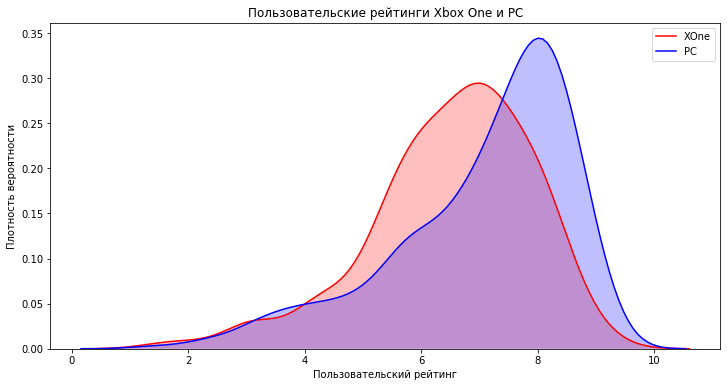

Медиана XOne 	:			 p50 = 6.8
Медиана PC 	:			 p50 = 7.5
Среднее XOne 	:			 μ = 6.52
Среднее PC 	:			 μ = 7.06
Дисперсия XOne 	:			 s^2 = 1.91
Дисперсия PC 	:			 s^2 = 2.34
Стандартное отклонение XOne 	:	 s = 1.38
Стандартное отклонение PC 	:	 s = 1.53


In [60]:
pd_compare(games.loc[(games['platform']=='XOne') & (games['user_score'] > 0)], \
           games.loc[(games['platform']=='PC') & (games['user_score'] > 0)], \
           'user_score', 'Пользовательские рейтинги Xbox One и PC','XOne', 'PC', 'Пользовательский рейтинг')

Похоже, что дисперсии выборок не сильно отличаются. Проверим это при помощи теста Левина. Положим критический уровень статистической значимости равной 1%.
    
H₀ - выборки взяты из популяций с равной дисперсией.
    
H₁ - выборки взяты из популяций с НЕ равной дисперсией.

In [61]:
alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу
    
results = levene(games.loc[(games['platform']=='XOne') & (games['user_score'] > 0)]['user_score'].dropna(), \
                        games.loc[(games['platform']=='PC') & (games['user_score'] > 0)]['user_score'].dropna(), \
                        center='mean')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.07549452472407711
Не получилось отвергнуть нулевую гипотезу


Мы не отвергаем нулевую гипотезу о том, что выборки взяты из популяций с равной дисперсией. Поэтому при проверке гипотезы через Т-критерий Стьюдента мы будем использовать параметр `equal_var = True` (по умолчанию) в методе `ttest_ind`.

Проверим гипотезу о равенстве среднего двух генеральных совокупностей (средние пользовательские рейтинги платформ Xbox One и PC) по взятым из них выборкам. Воспользуемся t-критерием Стьюдента. Так как выборки довольно большие (больше 100), положим уровень статистической значимости равным 1%.

H₀ - в нашей выборке средний пользовательский рейтинг платформы *Xbox One* равен среднему пользовательскому рейтингу платформы *PC*.

H₁ - в нашей выборке средний пользовательский рейтинг платформы *Xbox One* НЕ равен среднему пользовательскому рейтингу платформы *PC*.

In [62]:
alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    games.loc[(games['platform']=='XOne')& (games['user_score'] > 0)]['user_score'].dropna(), 
    games.loc[(games['platform']=='PC')& (games['user_score'] > 0)]['user_score'].dropna())

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.3896435533548819e-05
Отвергаем нулевую гипотезу


Мы принимаем  альтернативную гипотезу о том, что средний пользовательский рейтинг платформы Xbox One НЕ равен среднему пользовательскому рейтингу платформы PC.

## 5.2. Гипотеза 2<a class="anchor" id="section_5_2"></a>

**Гипотеза: Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.**

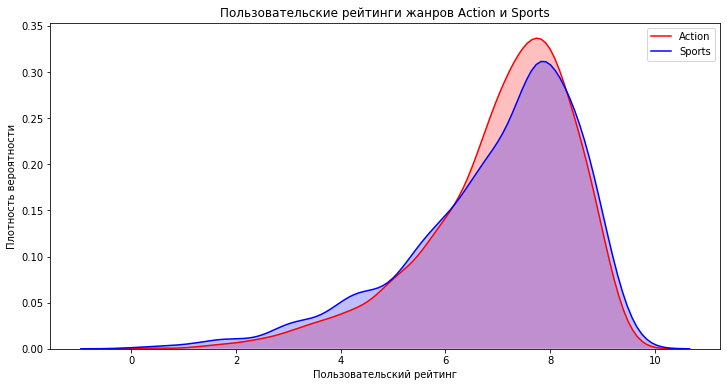

Медиана Action 	:			 p50 = 7.4
Медиана Sports 	:			 p50 = 7.4
Среднее Action 	:			 μ = 7.05
Среднее Sports 	:			 μ = 6.96
Дисперсия Action 	:			 s^2 = 2.03
Дисперсия Sports 	:			 s^2 = 2.6
Стандартное отклонение Action 	:	 s = 1.43
Стандартное отклонение Sports 	:	 s = 1.61


In [63]:
pd_compare(games.loc[(games['genre']=='Action') & (games['user_score'] > 0)], \
           games.loc[(games['genre']=='Sports') & (games['user_score'] > 0)], \
           'user_score', 'Пользовательские рейтинги жанров Action и Sports','Action', 'Sports', 'Пользовательский рейтинг')

H₀ - в нашей выборке средний пользовательский рейтинг жанра *Action* равен среднему пользовательскому рейтингу жанра *Sports*.

H₁ - в нашей выборке средний пользовательский рейтинг жанра *Action* НЕ равен среднему пользовательскому рейтингу жанра *Sports*.

In [64]:
alpha = .01 # критический уровень статистической значимости
            # если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(
    games.loc[(games['genre']=='Action')& (games['user_score'] > 0)]['user_score'].dropna(), 
    games.loc[(games['genre']=='Sports')& (games['user_score'] > 0)]['user_score'].dropna())

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.10406951359049141
Не получилось отвергнуть нулевую гипотезу


Мы не можем отвергнуть нулевую гипотезу о том, что в нашей выборке средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.

# Шаг 5. Общий вывод <a class="anchor" id="chapter5"></a>

- Наиболее удачные платформы "живут" 7-11 лет.  При этом набирают популярность платформы так же стремительно, как и теряют - за 2-3 года.
- Видно, что популярность стремительно возрастает для двух платформ: PS4 и Xbox One.
- Оценки критиков как правило лучше отражают популярность игр для платформы, чем оценки пользователей.
- Предпочтения по платформам и жанрам игр со временем меняются, поэтому будем считать актуальными данные за последние 3 года.
- Пользователи Северной Америки, как и пользователи Европы предполчитают PS4 другим платформам.
- Пользователи Северной Америки, как и пользователи Европы предполчитают PS4 другим платформам. 
- В Северной Америке XOne не так сильно отстаёт от PS4. 
- В Европе вероятно пользователи постепенно переходят с платформы PS3 на PS4 и XOne, но последняя проигрывает.
- В Японии пользователи предпочитают отечественного производителя, однако более популярной платформой является 3DS, а не PS4.
- Больше всего игр для популярных платформ продаётся в Северной Америке, чуть меньше - в Европе.
- В Северной Америке и Европе пользуются популярностью одни и те же жанры. Преобладают Action и Shooter. 
- В Японии самый популярный жанр - Role-Playing.
- В Северной Америке и Европе в основном играют пользователи категорий Mature(17+) и Everyone.
- В Японии примерно одинаково играют тинейджеры от 13 лет, Everyone и Mature(17+).
- Средний пользовательский рейтинг платформы Xbox One НЕ равен среднему пользовательскому рейтингу платформы PC.
- Мы не можем отвергнуть нулевую гипотезу о том, что в нашей выборке средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports.